# Loading Data

In [ ]:
import pandas as pd
import os

# Define the folder containing the files
folder_path = "/content/sample_data/DataSet"

# Get a list of all files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to store reviews
all_reviews = []

# Load reviews from each file
for file in file_list:
    print(f"Processing file: {file}")
    try:
        # Load the file into a DataFrame
        df = pd.read_csv(file)

        # Check if the 'review' column exists
        if 'imdb_reviews' in df.columns:
            # Append the 'review' column to the list
            all_reviews.extend(df['imdb_reviews'].dropna().tolist())
        else:
            print(f"'imdb_reviews' column not found in {file}. Skipping.")
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Create a DataFrame from all reviews
combined_reviews = pd.DataFrame(all_reviews, columns=['imdb_reviews'])

# Save to a new CSV file
output_file = "combined_reviews.csv"
combined_reviews.to_csv(output_file, index=False)

print(f"All reviews saved to {output_file}. Total reviews: {len(combined_reviews)}")


Processing file: /content/sample_data/DataSet/data_2016.csv
Processing file: /content/sample_data/DataSet/data_2019.csv
Processing file: /content/sample_data/DataSet/data_2020.csv
Processing file: /content/sample_data/DataSet/data_2018.csv
All reviews saved to combined_reviews.csv. Total reviews: 878


# PreProcess the Review

In [ ]:
combined_reviews = pd.read_csv('/content/combined_reviews.csv')

In [ ]:
import re

# Function to clean text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to all reviews
combined_reviews['cleaned_review'] = combined_reviews['imdb_reviews'].apply(clean_text)

print(combined_reviews.head())


                                        imdb_reviews  \
0  ["thank god this is up for rating. avoid the t...   
1  ['this movie has a fantastic plot and brings a...   
2  ["this is not a terrible movie, as some have s...   
3  ["i've been a tarzan fan for pretty much my wh...   
4  ["x-men apocalypse is the sequel to days of fu...   

                                      cleaned_review  
0  thank god this is up for rating avoid the thea...  
1  this movie has a fantastic plot and brings all...  
2  this is not a terrible movie as some have said...  
3  ive been a tarzan fan for pretty much my whole...  
4  xmen apocalypse is the sequel to days of futur...  


In [ ]:
combined_reviews.to_csv('/content/combined_reviews.csv', index=False)

# Label the data

In [ ]:
from transformers import pipeline
import pandas as pd

In [ ]:
# Load sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Function to map sentiments to desired labels
def map_sentiment(label):
    if label == "POSITIVE":
        return "positive"
    elif label == "NEGATIVE":
        return "negative"
    else:
        return "neutral"


In [ ]:
# Function to split long reviews into chunks of 512 tokens
def split_into_chunks(text, max_length=512):
    # Check if text is a string and not empty
    if isinstance(text, str) and text:
        # Tokenize the text (convert text to tokens)
        tokens = sentiment_analyzer.tokenizer.encode(text, truncation=True, max_length=max_length, padding=False)

        # Create chunks of text with the defined max length
        chunks = [tokens[i : i + max_length] for i in range(0, len(tokens), max_length)]

        # Decode the chunks back to text
        chunk_texts = [sentiment_analyzer.tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]
        return chunk_texts
    else:
        # Return an empty list if text is not valid
        return []

In [ ]:
# Function to get sentiment for long reviews
def get_sentiment_for_long_review(text):
    # Split the review into chunks
    chunks = split_into_chunks(text)

    # Get sentiment for each chunk
    sentiments = [sentiment_analyzer(chunk)[0]['label'] for chunk in chunks]

    # Determine the majority sentiment from all chunks
    majority_sentiment = max(set(sentiments), key=sentiments.count)

    # Map sentiment to desired label (positive, negative, neutral)
    return map_sentiment(majority_sentiment)



In [ ]:
# Load the reviews (replace with your actual file path)
combined_reviews = pd.read_csv("/content/combined_reviews (2).csv")

In [ ]:
import pandas as pd
import re

# Function to clean text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load the reviews
combined_reviews = pd.read_csv("/content/combined_reviews (2).csv")

# Apply cleaning to all reviews
combined_reviews['cleaned_review'] = combined_reviews['imdb_reviews'].apply(clean_text)

# 1. Remove null rows
combined_reviews = combined_reviews.dropna(subset=['cleaned_review'])

# 2. Remove rows with only "[]"
combined_reviews = combined_reviews[combined_reviews['cleaned_review'] != "[]"]

# 3. Remove rows with short reviews (less than 3 characters)
combined_reviews = combined_reviews[combined_reviews['cleaned_review'].str.len() > 3]

In [ ]:
# Auto-label reviews
combined_reviews['sentiment'] = combined_reviews['cleaned_review'].apply(
    lambda x: get_sentiment_for_long_review(x)
)

In [ ]:
# Save the labeled data
combined_reviews.to_csv("labeled_reviews.csv", index=False)
print("Labeled data saved to 'labeled_reviews.csv'.")


Labeled data saved to 'labeled_reviews.csv'.


# Convert 2 classs to 3 class

In [ ]:
import pandas as pd
f = pd.read_csv('/content/labeled_reviews.csv')

In [ ]:
f.head()

,imdb_reviews,cleaned_review,sentiment
0,"[""thank god this is up for rating. avoid the t...",thank god this is up for rating avoid the thea...,positive
1,['this movie has a fantastic plot and brings a...,this movie has a fantastic plot and brings all...,positive
2,"[""this is not a terrible movie, as some have s...",this is not a terrible movie as some have said...,negative
3,"[""i've been a tarzan fan for pretty much my wh...",ive been a tarzan fan for pretty much my whole...,positive
4,"[""x-men apocalypse is the sequel to days of fu...",xmen apocalypse is the sequel to days of futur...,negative


In [ ]:
reviews = f['cleaned_review'].tolist()

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def label_review(review):
    sentiment_score = analyzer.polarity_scores(review)['compound']
    if sentiment_score > 0.3:
        return "positive"
    elif sentiment_score < -0.3:
        return "negative"
    else:
        return "neutral"

# Example reviews
labels = [label_review(review) for review in reviews]
print(labels)


['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'pos

In [ ]:
# Apply labeling function
f["Label_02"] = f["cleaned_review"].apply(label_review)
    # Save the updated DataFrame to a new CSV file
f.to_csv('/content/labeled_reviews.csv', index=False)
f.head()

,imdb_reviews,cleaned_review,sentiment,Label_02
0,"[""thank god this is up for rating. avoid the t...",thank god this is up for rating avoid the thea...,positive,positive
1,['this movie has a fantastic plot and brings a...,this movie has a fantastic plot and brings all...,positive,positive
2,"[""this is not a terrible movie, as some have s...",this is not a terrible movie as some have said...,negative,positive
3,"[""i've been a tarzan fan for pretty much my wh...",ive been a tarzan fan for pretty much my whole...,positive,positive
4,"[""x-men apocalypse is the sequel to days of fu...",xmen apocalypse is the sequel to days of futur...,negative,positive


In [ ]:
# Count the number of each label
label_counts = f["Label_02"].value_counts()
print("Label counts:")
print(label_counts)

Label counts:
Label_02
positive    796
negative     67
neutral      11
Name: count, dtype: int64


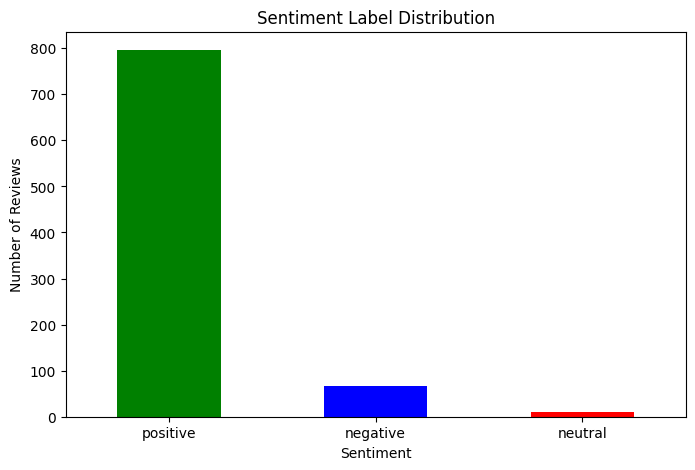

In [ ]:
import matplotlib.pyplot as plt
# Plot the label distribution
label_counts.plot(kind="bar", color=["green", "blue", "red"], figsize=(8, 5))
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

In [ ]:
f.head()

,imdb_reviews,cleaned_review,sentiment,Label_02
0,"[""thank god this is up for rating. avoid the t...",thank god this is up for rating avoid the thea...,positive,positive
1,['this movie has a fantastic plot and brings a...,this movie has a fantastic plot and brings all...,positive,positive
2,"[""this is not a terrible movie, as some have s...",this is not a terrible movie as some have said...,negative,positive
3,"[""i've been a tarzan fan for pretty much my wh...",ive been a tarzan fan for pretty much my whole...,positive,positive
4,"[""x-men apocalypse is the sequel to days of fu...",xmen apocalypse is the sequel to days of futur...,negative,positive


In [ ]:
f.drop('imdb_reviews', axis=1, inplace=True)

In [ ]:
f.drop('sentiment', axis=1, inplace=True)

In [ ]:
f.head()

,cleaned_review,Label_02
0,thank god this is up for rating avoid the thea...,positive
1,this movie has a fantastic plot and brings all...,positive
2,this is not a terrible movie as some have said...,positive
3,ive been a tarzan fan for pretty much my whole...,positive
4,xmen apocalypse is the sequel to days of futur...,positive


In [ ]:
f= f.rename(columns={'Label_02': 'sentiment','cleaned_review':'reviews'})
f.head()

,reviews,sentiment
0,thank god this is up for rating avoid the thea...,positive
1,this movie has a fantastic plot and brings all...,positive
2,this is not a terrible movie as some have said...,positive
3,ive been a tarzan fan for pretty much my whole...,positive
4,xmen apocalypse is the sequel to days of futur...,positive


In [ ]:
print(f['sentiment'].count())

874


In [ ]:
f.to_csv('/content/PreSMOT.csv', index=False)

## Blancing Data Through SMOT Process

In [ ]:
# Convert the labels to numeric values for SMOTE
label_mapping = {"positive": 0, "negative": 1, "neutral": 2}
f["LabelNum"] = f["sentiment"].map(label_mapping)

In [ ]:
from imblearn.over_sampling import SMOTE
# Separate features and labels
X = f["reviews"]  # Feature (e.g., review text)
y = f["LabelNum"]  # Numeric labels

In [ ]:
# Convert text features to numeric using TF-IDF or CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [ ]:
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)  # or try other strategies like 'minority'
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Map back to labels
label_mapping_reverse = {v: k for k, v in label_mapping.items()}
y_resampled_labels = pd.Series(y_resampled).map(label_mapping_reverse)

In [ ]:
# Combine back into a DataFrame
balanced_data = pd.DataFrame({
    "reviews": vectorizer.inverse_transform(X_resampled),
    "sentiment": y_resampled_labels
})

In [ ]:
# Save the balanced data
balanced_data.to_csv("AfterSMOT.csv", index=False)

print("Dataset has been balanced using SMOTE and saved to 'balanced_reviews.csv'.")


Dataset has been balanced using SMOTE and saved to 'balanced_reviews.csv'.


In [ ]:
balanced_data.head()

,reviews,sentiment
0,"[thank, god, this, is, up, for, rating, avoid,...",positive
1,"[this, is, up, for, the, still, being, in, the...",positive
2,"[this, is, for, the, still, in, movie, so, hav...",positive
3,"[this, is, up, for, the, in, theaters, movie, ...",positive
4,"[this, is, for, the, still, in, movie, got, so...",positive


In [ ]:
balanced_data['sentiment'].value_counts()

,count
sentiment,
positive,796
neutral,796
negative,796


# Now Traing the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Extract features (X) and labels (y) from the balanced dataset
X = balanced_data["reviews"].apply(lambda x: ' '.join(x))
y = balanced_data["sentiment"]

# Convert labels to numeric again for model training
y = y.map(label_mapping)

# Convert text features to numeric using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_vectorized = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
#The error was here. You were fitting a variable called 'model' but later calling predict on 'model_rf'.
#Change model.fit to model_rf.fit to train the RandomForest model
model_rf.fit(X_train, y_train)
# model = LogisticRegression()
# model.fit(X_train, y_train)

# Predict on the test set
y_pred = model_rf.predict(X_test) #Also change here from model.predict to model_rf.predict

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       163
           1       0.96      0.91      0.93       158
           2       0.99      1.00      1.00       157

    accuracy                           0.96       478
   macro avg       0.96      0.96      0.96       478
weighted avg       0.96      0.96      0.96       478

Confusion Matrix:
[[157   6   0]
 [ 14 143   1]
 [  0   0 157]]


# Save the model

In [ ]:
import joblib
joblib.dump(model, "review_classifier.pkl")

['review_classifier.pkl']

# Test the Model

In [66]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear']
}

# Initialize Logistic Regression model
model_lr = LogisticRegression()

# Perform Grid Search
grid_search = GridSearchCV(model_lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")


Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [80]:
# Get user input (simulating a textbox)
new_review = input("Enter your review: ")
# Preprocess and vectorize the input
new_review_vectorized = vectorizer.transform([new_review])

# Predict the sentiment
prediction = model_lr.predict(new_review_vectorized)

# Get the predicted label (positive/negative)
predicted_label = label_mapping_reverse[prediction[0]]
print(f"Prediction: {predicted_label}")


Enter your review: Extra ordinary movies
Prediction: positive


## Train on multiple Models

In [57]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model_lr = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model
model_lr.fit(X_train, y_train)

# Evaluate the model
y_pred_lr = model_lr.predict(X_test)
print("Logistic Regression Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       163
           1       1.00      0.95      0.97       158
           2       1.00      1.00      1.00       157

    accuracy                           0.98       478
   macro avg       0.98      0.98      0.98       478
weighted avg       0.98      0.98      0.98       478



In [58]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = model_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       163
           1       0.96      0.91      0.93       158
           2       0.99      1.00      1.00       157

    accuracy                           0.96       478
   macro avg       0.96      0.96      0.96       478
weighted avg       0.96      0.96      0.96       478



In [59]:
from sklearn.svm import SVC

# Initialize the Support Vector Machine (SVM) model
model_svm = SVC(kernel='linear', random_state=42)

# Train the model
model_svm.fit(X_train, y_train)

# Evaluate the model
y_pred_svm = model_svm.predict(X_test)
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svm))


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       163
           1       1.00      0.92      0.96       158
           2       1.00      1.00      1.00       157

    accuracy                           0.97       478
   macro avg       0.98      0.97      0.98       478
weighted avg       0.98      0.97      0.97       478



In [60]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes model
model_nb = MultinomialNB()

# Train the model
model_nb.fit(X_train, y_train)

# Evaluate the model
y_pred_nb = model_nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       163
           1       0.98      0.97      0.97       158
           2       0.99      1.00      0.99       157

    accuracy                           0.98       478
   macro avg       0.98      0.98      0.98       478
weighted avg       0.98      0.98      0.98       478



In [61]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
model_gb = GradientBoostingClassifier(random_state=42)

# Train the model
model_gb.fit(X_train, y_train)

# Evaluate the model
y_pred_gb = model_gb.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       163
           1       0.97      0.92      0.95       158
           2       1.00      1.00      1.00       157

    accuracy                           0.97       478
   macro avg       0.97      0.97      0.97       478
weighted avg       0.97      0.97      0.97       478



In [62]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the K-Nearest Neighbors model
model_knn = KNeighborsClassifier()

# Train the model
model_knn.fit(X_train, y_train)

# Evaluate the model
y_pred_knn = model_knn.predict(X_test)
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       163
           1       0.75      1.00      0.85       158
           2       0.96      1.00      0.98       157

    accuracy                           0.87       478
   macro avg       0.90      0.88      0.87       478
weighted avg       0.90      0.87      0.87       478



In [63]:
from sklearn.metrics import classification_report

# Collect all models and their predictions
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "SVM": model_svm,
    "Naive Bayes": model_nb,
    "Gradient Boosting": model_gb,
    "KNN": model_knn
}

# Evaluate and print classification reports for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       163
           1       1.00      0.95      0.97       158
           2       1.00      1.00      1.00       157

    accuracy                           0.98       478
   macro avg       0.98      0.98      0.98       478
weighted avg       0.98      0.98      0.98       478


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       163
           1       0.96      0.91      0.93       158
           2       0.99      1.00      1.00       157

    accuracy                           0.96       478
   macro avg       0.96      0.96      0.96       478
weighted avg       0.96      0.96      0.96       478


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       163
           1       

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Assuming that the models and vectorizer are already trained and saved
# Replace with your trained models and vectorizer
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "SVM": model_svm,
    "Naive Bayes": model_nb,
    "Gradient Boosting": model_gb,
    "KNN": model_knn
}

# Define label mapping (from numerical to categorical)
label_mapping_reverse = {0: "positive", 1: "negative", 2: "neutral"}

# Instead of creating a new CountVectorizer, use the one fitted during training
#Replace with your trained vectorizer, likely the one you used in a previous cell to train the model
vectorizer = TfidfVectorizer(max_features=5000)
# Assuming X contains your training data reviews
vectorizer.fit(X)  #Fit using the training data

def get_prediction(new_review):
    # Preprocess and vectorize the input
    new_review_vectorized = vectorizer.transform([new_review])

    # Loop through each model and get predictions
    predictions = {}
    for model_name, model in models.items():
        prediction = model.predict(new_review_vectorized)
        predicted_label = label_mapping_reverse[prediction[0]]
        predictions[model_name] = predicted_label

    return predictions

# Start an infinite loop to ask for user input until they quit
while True:
    # Get user input (simulating a textbox)
    new_review = input("Enter your review (or type 'quit' to exit): ")

    if new_review.lower() == 'quit':
        print("Exiting the program.")
        break

    # Get predictions for all models
    predictions = get_prediction(new_review)

    # Print out predictions for each model
    print("\nPredictions from different models:")
    for model_name, predicted_label in predictions.items():
        print(f"{model_name}: {predicted_label}")

    print("\n" + "-"*40 + "\n")

Enter your review (or type 'quit' to exit): Not happy with the purchase.

Predictions from different models:
Logistic Regression: positive
Random Forest: neutral
SVM: positive
Naive Bayes: negative
Gradient Boosting: positive
KNN: negative

----------------------------------------

Enter your review (or type 'quit' to exit): good movie

Predictions from different models:
Logistic Regression: positive
Random Forest: positive
SVM: positive
Naive Bayes: neutral
Gradient Boosting: positive
KNN: neutral

----------------------------------------

Enter your review (or type 'quit' to exit): not

Predictions from different models:
Logistic Regression: positive
Random Forest: neutral
SVM: positive
Naive Bayes: neutral
Gradient Boosting: positive
KNN: neutral

----------------------------------------

Enter your review (or type 'quit' to exit): not happy

Predictions from different models:
Logistic Regression: positive
Random Forest: neutral
SVM: positive
Naive Bayes: negative
Gradient Boosting:

In [83]:
import joblib

# Saving each model using joblib
joblib.dump(model_lr, 'model_lr.pkl')
joblib.dump(model_rf, 'model_rf.pkl')
joblib.dump(model_svm, 'model_svm.pkl')
joblib.dump(model_nb, 'model_nb.pkl')
joblib.dump(model_gb, 'model_gb.pkl')
joblib.dump(model_knn, 'model_knn.pkl')

print("All models have been saved successfully!")


All models have been saved successfully!


In [84]:
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Vectorizer has been saved successfully!")


Vectorizer has been saved successfully!


In [85]:
# Loading the models
model_lr = joblib.load('model_lr.pkl')
model_rf = joblib.load('model_rf.pkl')
model_svm = joblib.load('model_svm.pkl')
model_nb = joblib.load('model_nb.pkl')
model_gb = joblib.load('model_gb.pkl')
model_knn = joblib.load('model_knn.pkl')

# Loading the vectorizer
vectorizer = joblib.load('vectorizer.pkl')

print("Models and vectorizer have been loaded successfully!")


Models and vectorizer have been loaded successfully!


In [86]:
new_review = "This product is amazing!"
new_review_vectorized = vectorizer.transform([new_review])

predictions = {}
for model_name, model in models.items():
    prediction = model.predict(new_review_vectorized)
    predicted_label = label_mapping_reverse[prediction[0]]
    predictions[model_name] = predicted_label

# Print predictions
print(predictions)


{'Logistic Regression': 'positive', 'Random Forest': 'neutral', 'SVM': 'positive', 'Naive Bayes': 'positive', 'Gradient Boosting': 'positive', 'KNN': 'positive'}


In [87]:
import joblib

# Load the saved models and vectorizer
model_lr = joblib.load('model_lr.pkl')
model_rf = joblib.load('model_rf.pkl')
model_svm = joblib.load('model_svm.pkl')
model_nb = joblib.load('model_nb.pkl')
model_gb = joblib.load('model_gb.pkl')
model_knn = joblib.load('model_knn.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Define label mapping (reverse mapping from numeric to original label)
label_mapping_reverse = {0: 'positive', 1: 'negative', 2: 'neutral'}

# Store models in a dictionary
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "SVM": model_svm,
    "Naive Bayes": model_nb,
    "Gradient Boosting": model_gb,
    "KNN": model_knn
}

# Start an infinite loop to ask for user input until they quit
while True:
    # Get user input (simulating a textbox)
    new_review = input("Enter your review (or type 'quit' to exit): ")

    # If user wants to quit
    if new_review.lower() == 'quit':
        print("Exiting the program.")
        break

    # Preprocess and vectorize the input review
    new_review_vectorized = vectorizer.transform([new_review])

    # Initialize predictions dictionary
    predictions = {}

    # Loop through each model and get predictions
    for model_name, model in models.items():
        prediction = model.predict(new_review_vectorized)
        predicted_label = label_mapping_reverse[prediction[0]]
        predictions[model_name] = predicted_label

    # Print out predictions for each model
    print("\nPredictions from different models:")
    for model_name, predicted_label in predictions.items():
        print(f"{model_name}: {predicted_label}")

    print("\n" + "-"*40 + "\n")


Enter your review (or type 'quit' to exit): fuck you

Predictions from different models:
Logistic Regression: positive
Random Forest: neutral
SVM: positive
Naive Bayes: neutral
Gradient Boosting: positive
KNN: neutral

----------------------------------------

Enter your review (or type 'quit' to exit): worst movie

Predictions from different models:
Logistic Regression: negative
Random Forest: positive
SVM: positive
Naive Bayes: negative
Gradient Boosting: positive
KNN: negative

----------------------------------------

Enter your review (or type 'quit' to exit): amazing movie

Predictions from different models:
Logistic Regression: positive
Random Forest: positive
SVM: positive
Naive Bayes: negative
Gradient Boosting: positive
KNN: negative

----------------------------------------

Enter your review (or type 'quit' to exit): quit
Exiting the program.
